
# Code Intent Prediction
## With Applied Machine Learning Techniques
***
### Justin Hugh
#### Data Science Diploma Candidate, BrainStation
##### December 18, 2020

***

# Table of Contents
## [ Introduction](#Introduction)
## [ Limitations and Assumptions](#Limitations-and-Assumptions)
## [ Background](#Background)
## [ The Data](#The-Data)
- ### [ Sources of Data](#Sources-of-Data)  
    - #### [ CoNaLa](#CoNaLa)
- ### [ Data Characteristics](#Data-Characteristics)  

## [ Exploratory Data Analysis](#Exploratory-Data-Analysis)  
- ### [ Importing Data](#Importing-Data)   
    - #### [ CoNaLa Competition Data](#CoNaLa-Competition-Data)  
    - #### [ CoNaLa Mined Data](#CoNaLa-Mined-Data)
- ### [ Intent Paradigms](#Intent-Paradigms)  

## [ Modelling and Analysis](#Modelling-and-Analysis)
    
## [ Conclusion](#Conlusion)  
## [ References](#References)

***

# Introduction
[[Back to TOC]](#Table-of-Contents)

Software and code are becoming present nearly everywhere in our daily lives both personal and professional, yet only a fraction of us are literate in code. Even among those, there exists a wide range of languages and frameworks so no one is familiar with it all. 

I propose a model which could predict the intent or purpose of a sample of code. A tool like this would help us understand more of the world around us and would be hugely impactful for:  
- Education. Making code more accessible and interpretable.  
- Security. Identifying code with malicious intent.  
- Development. Providing contextual tooltips, suggestions, resources.   

The goal of this project is to develop an ML model employing NLP tools to interpret what a piece of code is trying to accomplish.

***

# Limitations and Assumptions
[[Back To TOC]](#Table-of-Contents)

In this section I'll recognize some of the limitiations and assumptions to the modelling and analysis I will conduct. Those listed here will are generally applicable to the project at large. Any that are more specifically applicable to a certain step are discussed at that point in the analysis.

- Some of this data is not current. One of the main sources of the data comes from a competition which was conducted in 2018. Software changes quite quickly since updates to packages are relatively cheaply accomplished. My model and this system's performance may be less applicable to presently constructed code, and will deprecate over time as libraries and languages are updated.

- I assume this data set does not have known significant errors, such as incorrect application of code or erroneous syntax. If these are present in abundance, then this system's performance will have "learned" incorrect code application. 

- Developers are not uniquely identified in the data I've used. Not having this information restricts me from making more deep insights into code and intent on a developer-by-developer level which could potentially mean more accurate interpretations. However, this is a good and necessary practice from a privacy and standpoint. If developers were uniquely identified in the data, this could potentially be used to reconstruct personal data, constituting a notable privacy concern.

***

# Background
[[Back To TOC]](#Table-of-Contents)

In any project it's important to recognize the context of what's being investigated and how, other than the just code and the model we create. In this section, we'll discuss the important subject matter surround the problems we're tackling. 

## Packages and Libraries
[[Back To TOC]](#Table-of-Contents)

There's a wealth of support openly available in the form of packages for Machine Learning, and other problem areas I'll touch on in this project. 

I import some necessary ones below in this section. 

In [1]:
# The usual packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Import
import pickle

# Data Wrangling
from sklearn.model_selection import train_test_split 
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingClassifier

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp

# The classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import string
from sklearn.neighbors import NearestNeighbors

# runtime
from tqdm import tqdm
import time 
import warnings
warnings.filterwarnings("ignore")

# timeseries
from statsmodels.api import tsa
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

***

# The Data
[[Back To TOC]](#Table-of-Contents)

A model is only as good as the data it uses. In this section I'll discuss the inputs in this project; where it comes from, what it looks like, and how I hope to use it.

## Sources of Data
[[Back To TOC]](#Table-of-Contents)

To acquire the data used in this project, I accessed numerous resources hoping to create a balance. On one hand, I was able to find some well-structured and cleaned data, and on the other, in order to bolster the amount of data I had, I accessed other data sets. 

&&&&&&& Conducting some scraping and intent learning myself? &&&&&&&&&&

I'll discuss where we obtained the data below. It's important to note where the data used to train the model I've created comes from. With that understanding it's possible to see some quirks, patterns, and other important information to keep in mind throughout this project.

### CoNaLa

[_The Code/Natural Language Challenge (CoNaLa)_](https://conala-corpus.github.io/#dataset-information) is a challenge that was created by [_Carnegie Mellon University (CMU)_](https://www.cmu.edu/) along with [_NeuLab_](http://www.cs.cmu.edu/~neulab/) and [_STRUDEL Lab_](https://cmustrudel.github.io/) on May 31, 2018 in order to test systems for generating programs from natural language [[1]](#References). The original intent was to - given an english input such as "sort list x in reverse order" - have a system output `x.sort(reverse=True)` in Python. 

_CoNaLa_ is a competition with no end date, and are offered for use within the challenge itself, or any other research on the intersection of code and natural languague - which this project falls nicely into.

_CoNaLa_ provides a wealth of publicly available data which is well suited for the needs of this project (and ours) including: 
- Data crawled from _Stack Overflow_ with 2,379 training examples, and 500 test examples. These have been curated by annotators.
- Automatically-mined data with 600,000 examples. 
- Links to other helpful and similar data sets:
    - [Django Dataset](https://ahcweb01.naist.jp/pseudogen/)  
    - [StaQC](https://github.com/LittleYUYU/StackOverflow-Question-Code-Dataset)[3]  
    - [Code Docstring Corpus](https://github.com/EdinburghNLP/code-docstring-corpus)[4]  
    
&&&&
I accessed these data in a couple different ways (direct download from CoNaLa, git, etc.)
&&&&

## Data Characteristics
[[Back To TOC]](#Table-of-Contents)


# Exploratory Data Analysis
[[Back To TOC]](#Table-of-Contents)

The purpose of Exploratory Data Analysis (EDA) is to familiarize ourselves with the data, determine whether it has missing values or other deficiencies, clean the data so it may be analyzed, and peek at some of the more immediately evident relations of the data and parameters we're working with. By the end of these activities, we will have a cleaned set of data which is prepared for modelling and deeper analysis.

## Importing Data
[[Back To TOC]](#Table-of-Contents)

Our data come from a variety of different sources, each requiring a different workflow in order to bring into this workbook and analyze. In this section we'll outline our methods for doing this. And import the data itself.

### CoNaLa Competition Data
[[Back To TOC]](#Table-of-Contents)


In [2]:
# CoNaLa Training Data

# Open file, handle with `with` and load the contents which are contained as a json object.
# Instantiate conala_train_data to hold the data.
with open('data/conala-corpus/conala-train.json') as f:
    conala_train_data = json.load(f)

In [3]:
conala_train_data

[{'intent': 'How to convert a list of multiple integers into a single integer?',
  'rewritten_intent': "Concatenate elements of a list 'x' of multiple integers to a single integer",
  'snippet': 'sum(d * 10 ** i for i, d in enumerate(x[::-1]))',
  'question_id': 41067960},
 {'intent': 'How to convert a list of multiple integers into a single integer?',
  'rewritten_intent': 'convert a list of integers into a single integer',
  'snippet': "r = int(''.join(map(str, x)))",
  'question_id': 41067960},
 {'intent': 'how to convert a datetime string back to datetime object?',
  'rewritten_intent': "convert a DateTime string back to a DateTime object of format '%Y-%m-%d %H:%M:%S.%f'",
  'snippet': "datetime.strptime('2010-11-13 10:33:54.227806', '%Y-%m-%d %H:%M:%S.%f')",
  'question_id': 4170655},
 {'intent': 'Averaging the values in a dictionary based on the key',
  'rewritten_intent': 'get the average of a list values for each key in dictionary `d`)',
  'snippet': '[(i, sum(j) / len(j)) for 

In [4]:
# CoNaLa Test Data

# Open file
# Instantiate conala_test_data to hold the data.
with open('data/conala-corpus/conala-test.json') as f:
    conala_test_data = json.load(f)

In [5]:
conala_test_data

[{'intent': 'How can I send a signal from a python program?',
  'rewritten_intent': 'send a signal `signal.SIGUSR1` to the current process',
  'snippet': 'os.kill(os.getpid(), signal.SIGUSR1)',
  'question_id': 15080500},
 {'intent': 'Decode Hex String in Python 3',
  'rewritten_intent': "decode a hex string '4a4b4c' to UTF-8.",
  'snippet': "bytes.fromhex('4a4b4c').decode('utf-8')",
  'question_id': 3283984},
 {'intent': 'check if all elements in a list are identical',
  'rewritten_intent': 'check if all elements in list `myList` are identical',
  'snippet': 'all(x == myList[0] for x in myList)',
  'question_id': 3844801},
 {'intent': 'Format string dynamically',
  'rewritten_intent': 'format number of spaces between strings `Python`, `:` and `Very Good` to be `20`',
  'snippet': "print('%*s : %*s' % (20, 'Python', 20, 'Very Good'))",
  'question_id': 4302166},
 {'intent': 'How to convert a string from CP-1251 to UTF-8?',
  'rewritten_intent': None,
  'snippet': "d.decode('cp1251').en

In [6]:
# Create DataFrames from the CoNaLa train and test sets, both from a list of dictionary objects
conala_train_df = pd.DataFrame.from_dict(conala_train_data)
conala_test_df = pd.DataFrame.from_dict(conala_test_data)


# Peek at the dfs
display(conala_test_df.head())
display(conala_train_df.head())

,intent,rewritten_intent,snippet,question_id
0,How can I send a signal from a python program?,send a signal `signal.SIGUSR1` to the current ...,"os.kill(os.getpid(), signal.SIGUSR1)",15080500
1,Decode Hex String in Python 3,decode a hex string '4a4b4c' to UTF-8.,bytes.fromhex('4a4b4c').decode('utf-8'),3283984
2,check if all elements in a list are identical,check if all elements in list `myList` are ide...,all(x == myList[0] for x in myList),3844801
3,Format string dynamically,format number of spaces between strings `Pytho...,"print('%*s : %*s' % (20, 'Python', 20, 'Very G...",4302166
4,How to convert a string from CP-1251 to UTF-8?,None,d.decode('cp1251').encode('utf8'),7555335


,intent,rewritten_intent,snippet,question_id
0,How to convert a list of multiple integers int...,Concatenate elements of a list 'x' of multiple...,"sum(d * 10 ** i for i, d in enumerate(x[::-1]))",41067960
1,How to convert a list of multiple integers int...,convert a list of integers into a single integer,"r = int(''.join(map(str, x)))",41067960
2,how to convert a datetime string back to datet...,convert a DateTime string back to a DateTime o...,datetime.strptime('2010-11-13 10:33:54.227806'...,4170655
3,Averaging the values in a dictionary based on ...,get the average of a list values for each key ...,"[(i, sum(j) / len(j)) for i, j in list(d.items...",29565452
4,zip lists in python,"zip two lists `[1, 2]` and `[3, 4]` into a lis...","zip([1, 2], [3, 4])",13704860


### CoNaLa Mined Data
[[Back To TOC]](#Table-of-Contents)

In [7]:
# CoNala Mined Data

# This file is different in format from the other CoNaLa Competition Data, 
# and contains multiple json objects. We need to handle it differently.

# First instantiate an empty list, this will be used hold all of the dictionary objects as a list
# of dictionaries.
conala_mined_data_list = []

# Open file, loop through the json objects in the file, appending the list each time. 
with open('data/conala-corpus/conala-mined.jsonl') as f:
    for jsonObj in tqdm(f):
        code_dic = json.loads(jsonObj)
        conala_mined_data_list.append(code_dic)

593891it [00:05, 118070.21it/s]


In [8]:
conala_mined_data_list[::-1]

[{'parent_answer_post_id': 39398969,
  'prob': 3.0130267068701258e-05,
  'snippet': 'tr\nfold',
  'intent': 'Script works differently when ran from the terminal and ran from Python',
  'id': '39397034_39398969_13',
  'question_id': 39397034},
 {'parent_answer_post_id': 41140750,
  'prob': 4.903111128849962e-05,
  'snippet': 'Red\nBlue',
  'intent': 'BeautifulSoup: just get inside of a tag, no matter how many enclosing tags there are',
  'id': '2957013_41140750_6',
  'question_id': 2957013},
 {'parent_answer_post_id': 5180297,
  'prob': 7.572041759033881e-05,
  'snippet': 'import re\nRawPurchaseAmount',
  'intent': 'Python Remove Comma In Dollar Amount',
  'id': '5180184_5180297_5',
  'question_id': 5180184},
 {'parent_answer_post_id': 5180297,
  'prob': 7.73206863173198e-05,
  'snippet': 'RawPurchaseAmount',
  'intent': 'Python Remove Comma In Dollar Amount',
  'id': '5180184_5180297_4',
  'question_id': 5180184},
 {'parent_answer_post_id': 2957181,
  'prob': 7.832874238417845e-05,
  '

In [9]:
conala_mined_df = pd.DataFrame(conala_mined_data_list)

In [10]:
# Peek at the DataFrame for the mined CoNaLa data.
conala_mined_df.head()

,parent_answer_post_id,prob,snippet,intent,id,question_id
0,34705233,0.869000,"sorted(l, key=lambda x: (-int(x[1]), x[0]))",Sort a nested list by two elements,34705205_34705233_0,34705205
1,13905946,0.852670,[int(x) for x in str(num)],converting integer to list in python,13905936_13905946_0,13905936
2,13838041,0.852143,c.decode('unicode_escape'),Converting byte string in unicode string,13837848_13838041_0,13837848
3,23490179,0.850829,"parser.add_argument('-t', dest='table', help='...",List of arguments with argparse,23490152_23490179_0,23490152
4,2721807,0.840372,"datetime.datetime.strptime(s, '%Y-%m-%dT%H:%M:...",How to convert a Date string to a DateTime obj...,2721782_2721807_0,2721782


Note that the index is not random, the records are sorted such that the probabilities decrease along the list. That is, the lower the rank of the index, the higher the probability score.

In [11]:
# Looking at the DataFrame's statistics for numerical columns.
conala_mined_df.describe()

,parent_answer_post_id,prob,question_id
count,5.938910e+05,593891.000000,5.938910e+05
mean,1.859959e+07,0.064413,1.672431e+07
std,1.260624e+07,0.085104,1.227807e+07
min,5.950000e+02,0.000030,5.020000e+02
25%,7.669063e+06,0.016376,6.196250e+06
50%,1.657090e+07,0.034263,1.416615e+07
75%,2.960653e+07,0.074638,2.565613e+07
max,4.277310e+07,0.869000,4.277182e+07


The numbers for the `parent_answer_post_id` and `question_id` columns are not too meaninful since the numbers stored in these columns are nominal.

The statistics we see for the `prob` column is quite informative here. Of note, the mean probability is very low, at 6.4%, and even the 75th percentile is much lower than expected at 7.5%. This means there are far fewer records here where the code snippet is confidently associated with an intent than I was hoping for. This problem is discussed in the study which produced this mined code: 

> existing heuristic methods (e.g., pairing the title of a post with the code in the accepted answer) are limited both in their coverage and the
correctness of the NL-code pairs obtained.

To get a better intuition for how this `prob` score describes the association of the given `intent` and `snippet` I manually sampled the data and reviewed it.

In [12]:
# First sample from the whole DataFrame, look at the results.
conala_mined_df[conala_mined_df['prob']>0.5].sample(10)

,parent_answer_post_id,prob,snippet,intent,id,question_id
2960,12492429,0.512981,"sum(map(ord, string))",Python sum of ASCII values of all characters i...,12492137_12492429_1,12492137
844,5235358,0.619624,"self.treeview.connect('size-allocate', self.tr...",How to auto-scroll a gtk.scrolledwindow?,5218948_5235358_0,5218948
721,27436801,0.629923,print('.'.join([item[0] for item in data])),Python: reduce (list of strings) -> string,27436748_27436801_0,27436748
2633,15474969,0.524570,[y for y in a if y not in b],List comprehension with if statement,15474933_15474969_0,15474933
3148,6508110,0.507140,nums.search('0001.20000').group(0),Regular expression to find any number in a string,6508043_6508110_0,6508043
41,2621685,0.762161,"[a[i] for i in (1, 2, 5)]",how to extract elements from a list in python?,2621674_2621685_0,2621674
441,23749057,0.660919,df['a'].values.tolist(),Pandas DataFrame to list,23748995_23749057_1,23748995
2035,3296782,0.548857,theset = set(k.lower() for k in thedict),Case insensitive dictionary search with Python,3296499_3296782_0,3296499
16,9775761,0.797127,"max(min(my_value, max_value), min_value)",Clamping floating numbers in Python?,9775731_9775761_0,9775731
1533,7742808,0.573507,"sorted(list(y.items()), key=lambda x: (x[1], x...",Sorting a dictionary by value then by key,7742752_7742808_0,7742752


In [13]:
# Sample from the DataFrame, among records with prob > 0.5.
conala_mined_df[conala_mined_df['prob']>0.5].sample(10)

,parent_answer_post_id,prob,snippet,intent,id,question_id
2207,8531491,0.540664,plt.show(),How can I place a table on a plot in Matplotlib?,8524401_8531491_0,8524401
2306,20374507,0.536506,"{'y2': 2, 'y1': 1, 'x2': 2, 'x3': 3, 'y3': 3, ...",How to construct a dictionary from two diction...,20374415_20374507_0,20374415
750,13905946,0.627613,"map(int, str(num))",converting integer to list in python,13905936_13905946_1,13905936
1124,5669301,0.599455,"ax.plot(x, y, 'bo')",Python/Matplotlib - Is there a way to make a d...,5656798_5669301_1,5656798
1731,42330879,0.563648,"[['z', '+', '2', '-', '44'], ['4', '+', '55', ...",How to properly split this list of strings?,42330795_42330879_0,42330795
474,14694669,0.656478,print(soup.get_text()),Converting html to text with Python,14694482_14694669_1,14694482
790,6187741,0.624686,"struct.unpack('4b', struct.pack('I', 100))",How to convert integer value to array of four ...,6187699_6187741_0,6187699
678,3954926,0.633472,datetime.datetime.now().date(),How do I convert datetime to date (in Python)?,3743222_3954926_0,3743222
343,104471,0.674376,"itertools.permutations([1, 2, 3])",How to generate all permutations of a list in ...,104420_104471_0,104420
2750,31744384,0.520575,"print([u for v in [[i, i] for i in range(5)] f...",Create a list of integers with duplicate value...,31743603_31744384_2,31743603


In [14]:
# Use cell to view full contents of intent and snippet strings for specific 
# records in the sample, by its index.
ind = 143
print(conala_mined_df.loc[ind,'intent'])
print(conala_mined_df.loc[ind,'snippet'])

How to delete a record in Django models?
SomeModel.objects.filter(id=id).delete()


In [15]:
# Store this record result in helper csv file to aid manually viewing individual
# records as a random sample. 
with open('prob_explore.csv', mode='a+') as f:
    pd.DataFrame(conala_mined_df.loc[ind]).T.to_csv(f, mode='a+', header=False)

In [16]:
# Then look at samples with the 
conala_mined_df[conala_mined_df['prob']>0.5].sample(10)

,parent_answer_post_id,prob,snippet,intent,id,question_id
410,19585658,0.665701,"p = subprocess.Popen(cmd, stdout=sys.stdout, s...",How can I call a python script from a python s...,18366517_19585658_0,18366517
246,14775604,0.688914,"linregress(df['col_X'], df['col_Y'])",How to apply linregress in Pandas bygroup,14775068_14775604_0,14775068
1050,8194178,0.604524,"[(x1 - x2) for x1, x2 in zip(List1, List2)]",How to subtract two lists in python,8194156_8194178_0,8194156
43,27760083,0.757400,"driver.execute_script('window.scrollTo(0, docu...",How can I scroll a web page using selenium web...,20986631_27760083_0,20986631
389,5306100,0.668057,"map(int, ['1', '-1', '1'])",Python: How do I convert an array of strings t...,5306079_5306100_0,5306079
928,19308462,0.611776,"subprocess.call('start /wait python bb.py', sh...",Execute terminal command from python in new te...,19308415_19308462_0,19308415
902,29360674,0.613976,print(' '.join(OrderedDict.fromkeys(s))),How does this function to remove duplicate cha...,29360607_29360674_2,29360607
1748,32792883,0.562675,"[key for item in lst for key, value in list(my...",Searching if the values on a list is in the di...,32792874_32792883_0,32792874
1402,14180875,0.582080,[sum(x) for x in zip(*l)],sum each value in a list of tuples,14180866_14180875_1,14180866
272,21804966,0.684089,subprocess.call('mv /home/somedir/subdir/* som...,How to use the mv command in Python with subpr...,21804935_21804966_0,21804935


After conducting multiple samples of the data, and with inspection of the columns `intent` and `snippet`, I've concluded that the the code snippets with low probability scores in the mined data are not very strongly related with the intent they have been mined with. I will remove a large number of the records based on the prob score they have. Through the exploration and sampling above, I've learned that many records which have a probability of %50 or greater are quite reasonably associated with their code snippet. 

In the cell below we can determine how many records meet this threshold.

In [17]:
# Can use this function to determine how many records have a probability greater than `prob_thresh`
prob_thresh = 0.5
len(conala_mined_df[conala_mined_df["prob"]>prob_thresh])

3385

In [18]:
# Use the mined_df with only the records with probability greater than 50%. 
conala_mined_df = conala_mined_df[conala_mined_df['prob']>prob_thresh]

In [19]:
conala_mined_df

,parent_answer_post_id,prob,snippet,intent,id,question_id
0,34705233,0.869000,"sorted(l, key=lambda x: (-int(x[1]), x[0]))",Sort a nested list by two elements,34705205_34705233_0,34705205
1,13905946,0.852670,[int(x) for x in str(num)],converting integer to list in python,13905936_13905946_0,13905936
2,13838041,0.852143,c.decode('unicode_escape'),Converting byte string in unicode string,13837848_13838041_0,13837848
3,23490179,0.850829,"parser.add_argument('-t', dest='table', help='...",List of arguments with argparse,23490152_23490179_0,23490152
4,2721807,0.840372,"datetime.datetime.strptime(s, '%Y-%m-%dT%H:%M:...",How to convert a Date string to a DateTime obj...,2721782_2721807_0,2721782
...,...,...,...,...,...,...
3380,795000,0.500243,{{(item.date | date): 'Y M d'}},How to convert datetime to string in python in...,794995_795000_0,794995
3381,18145399,0.500193,"df = df.drop('column_name', 1)",Delete column from pandas DataFrame,13411544_18145399_2,13411544
3382,40584271,0.500171,"reverse_d = {value: key for key, values in lis...",How to get a list which is a value of a dictio...,40584186_40584271_0,40584186
3383,3227931,0.500164,config_file = os.path.expanduser('~/foo.ini'),Cross-platform addressing of the config file,3227624_3227931_0,3227624


We have have three DataFrames now. Let's look at their shapes and column names. We should compare them to make sure they are consistent, or create a plan for making them consistent.

In [20]:
# Summarize the shapes
print("Shape of CoNaLa train df:", conala_train_df.shape)
print("Shape of CoNaLa test df:", conala_test_df.shape)
print("Shape of CoNaLa mined df:", conala_mined_df.shape)

print("\nColumns of CoNaLa train df:\n", conala_train_df.columns)
print("\nColumns of CoNaLa test df:\n", conala_test_df.columns)
print("\nColumns of CoNaLa mined df:\n", conala_mined_df.columns)

Shape of CoNaLa train df: (2379, 4)
Shape of CoNaLa test df: (500, 4)
Shape of CoNaLa mined df: (3385, 6)

Columns of CoNaLa train df:
 Index(['intent', 'rewritten_intent', 'snippet', 'question_id'], dtype='object')

Columns of CoNaLa test df:
 Index(['intent', 'rewritten_intent', 'snippet', 'question_id'], dtype='object')

Columns of CoNaLa mined df:
 Index(['parent_answer_post_id', 'prob', 'snippet', 'intent', 'id',
       'question_id'],
      dtype='object')


The `conala_mined_df` has three columns that are the same as the other two, and is missing one column. 

Same columns:
- `question_id`
- `snippet`
- `intent`

Missing Column:
- `rewritten_intent`

The `question id` appears to be used as an index. I should be able to do the same, but will have to check with the mined data that the numbers don't overlap as these need to be unique.

The `snippet` column is where the snippets of code are contained. It's very likely that this column shouldn't be modified before being vectorized since this is the data that I'm trying to interpret and I do not want to introduce bias. When I conduct vectorizing on this shortly, there will be some decisions to be made about how to break up the data.

The `intent` column contains plain english questions submitted by developers to [Stack Overflow](#stackoverflow.com), in order to achieve certain tasks. This contains information about **desired intent**. Unfortunately most of these are written as questions and so the intent is not structured as preferred. 

The `rewritten_intent` column is a colum which has been viewed by the CoNaLa team to create a more plain-english description about the code in question. This will be extremely helpful since this represents some preliminary cleaning which has already been done for me. Unfortunately this doesn't exist for the `conala_mined_df` so I'll have to determine how to either create it, or handle the disparity.

This is a good time to export the data to a readable format for me to review visually.

In [28]:
# Export to csv for readability.
conala_train_df.to_csv(r'conala_train_df.csv')
conala_test_df.to_csv(r'conala_train_df.csv')
# This is a big dataset so we should reduce it 
conala_mined_df.to_csv(r'conala_train_df.csv')

## Count Vectorizing
[[Back To TOC]](#Table-of-Contents)

### Vectorizing `conala_train_df`

In [29]:
# Check for nan
conala_train_df.isna().sum()

intent              0
rewritten_intent    0
snippet             0
question_id         0
dtype: int64

In [30]:
# Fill with ""
conala_train_df.fillna('', inplace=True)

conala_train_df.isna().sum()

intent              0
rewritten_intent    0
snippet             0
question_id         0
dtype: int64

In [84]:
# Instantiate 
conala_train_bagofwords = CountVectorizer(stop_words="english", min_df=5)

# Fit 
conala_train_bagofwords.fit(conala_train_df["rewritten_intent"])

# Transform with the bag of words.
conala_train_bag_SM = conala_train_bagofwords.transform(conala_train_df["rewritten_intent"])
conala_train_bag_SM

<2379x435 sparse matrix of type '<class 'numpy.int64'>'
	with 10451 stored elements in Compressed Sparse Row format>

In [85]:
# Create a DataFrame (more workable) from the Sparse Matrix 
conala_train_bag_df = pd.DataFrame(columns=conala_train_bagofwords.get_feature_names(),
                                   data=conala_train_bag_SM.toarray())

In [86]:
conala_train_bag_df.sum().sort_values(ascending=False)

list           781
string         665
dictionary     238
value          236
values         235
              ... 
fields           5
org              5
comparison       5
punctuation      5
ending           5
Length: 435, dtype: int64

### Vectorizing `conala_test_df`

In [87]:
# Check for nan
conala_test_df.isna().sum()

intent              0
rewritten_intent    0
snippet             0
question_id         0
dtype: int64

In [88]:
# Fill with ""
conala_test_df.fillna('', inplace=True)

conala_test_df.isna().sum()

intent              0
rewritten_intent    0
snippet             0
question_id         0
dtype: int64

In [89]:
# Transform with the bag of words from the train df
conala_test_bag_SM = conala_train_bagofwords.transform(conala_test_df["rewritten_intent"])
conala_test_bag_SM

<500x435 sparse matrix of type '<class 'numpy.int64'>'
	with 2023 stored elements in Compressed Sparse Row format>

In [90]:
# Create a DataFrame (more workable) from the Sparse Matrix 
conala_test_bag_df = pd.DataFrame(columns=conala_train_bagofwords.get_feature_names(),
                                   data=conala_test_bag_SM.toarray())

Since this is our test set, we shouldn't peek at the results of the transformation here.

### Vectorizing `conala_mined_df`

We should have less confidence in the `intent` field contained in `conala_mined_df`, since this field is coming from a procedurally collected dataset, and has not been manually cleaned like that of the trained data. Because of this I'm proposing to use the bag of words we have fit to the train dataset in order to transform the mined dataset here. This will (hopefully) have the effect of identifying the words that should be considered as signficant to determining intent, as indicated by the fit on the training data set.

In [94]:
# Check for nan
conala_mined_df.isna().sum()

parent_answer_post_id    0
prob                     0
snippet                  0
intent                   0
id                       0
question_id              0
dtype: int64

In [95]:
# Transform with the bag of words from the train df
conala_mined_bag_SM = conala_train_bagofwords.transform(conala_mined_df["intent"])
conala_mined_bag_SM

<3385x435 sparse matrix of type '<class 'numpy.int64'>'
	with 12370 stored elements in Compressed Sparse Row format>

The number of stored elements from the mined df is a bit low. This may not be a good way of interpreting the mined code. There's some things we can try/consider: 

- graph min_df, and look at vocab size as WELL as elements contained. as WELL as vocab:records, elements:records. 

- only some of the mined records have high probability anyways, maybe we can filter out low probabilities and try again.
- maybe we filter out the rows that have no words in the bag of words which will cut down the data anways
- maybe both.

In [92]:
# Create a DataFrame (more workable) from the Sparse Matrix 
conala_mined_bag_df = pd.DataFrame(columns=conala_train_bagofwords.get_feature_names(),
                                   data=conala_mined_bag_SM.toarray())

In [93]:
conala_mined_bag_df.sum().sort_values(ascending=False)

python    1631
list       772
string     488
pandas     391
using      241
          ... 
df2          0
mydict       0
var          0
lower        0
com          0
Length: 435, dtype: int64

### Comparing the Vectorized `conala_mined_df` and `conala_trained_df`

In [108]:
conala_train_bag_df.sum().index==conala_mined_bag_df.sum().index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [104]:
conala_train_bag_df.sum().values
conala_mined_bag_df.sum().values

array([ 10,  24,   8,  12,  12,   7,   6,   7,   9,   6,  11,   5,   5,
         5,   7,   7,   9,  24,   7,  21,   8,   5,  14,  10, 152,  11,
        22,  19,   9,  18,  21,   5,   5,   8,   6,  15,  17,  44,   7,
        14,   7,   5,  27,   5,   7,   7,   6,   8,  10,  17,  23,  52,
        76, 100,  15,   8,  18,   7, 181,   5,  56,  24,   6,   6,  12,
        33,   5,   8,   5,  13,   5,   5,   9,  50,  21,  10,  11, 187,
         8,  11,  11,  28, 100,   7,  38,  47,   7,   6, 120, 196,   6,
        61,  38,  15,  43,  14,  10,   5,  36,  13,  17, 168,  10,  12,
        28,  42, 238,   9,  18,  12,   9,   9,  51,   9,   7,   6,  37,
         8,   6,   6,   6,   5,  14,   5,   5,   6, 109, 122,   9,   9,
         6,  15,   5,   5,   5,  10,  37,   7,   6,  11,   9,  20,   8,
        21,  15,  10,  29,  13,   5, 167,  21,  14,  16,  10,  10,  27,
         9,   7,   7,   7,  36,   9,  58,  12,  47,  27,  26,   6,   6,
         9,  13,  20,   6,   7,   6,   7,  24,  36,  12,   5,  1

In [113]:
# Create a df for comparison of word frequency in bag of words
bag_df = pd.DataFrame(data={"train_freq":conala_train_bag_df.sum().values, "mined_freq":conala_mined_bag_df.sum().values},
             index=conala_train_bag_df.sum().index)

In [116]:
# Inspecting the most common terms of the bag of words.
display(bag_df.sort_values(by="train_freq", ascending=False))
display(bag_df.sort_values(by="mined_freq", ascending=False))

,train_freq,mined_freq
list,781,772
string,665,488
dictionary,238,204
value,236,142
values,235,202
...,...,...
ends,5,1
concatenating,5,2
average,5,10
attributes,5,4


,train_freq,mined_freq
python,80,1631
list,781,772
string,665,488
pandas,107,391
using,126,241
...,...,...
delay,5,0
bigger,5,0
org,5,0
old_list,6,0


In [117]:
train_bag_sorted = bag_df.sort_values(by="train_freq", ascending=False)

In [127]:
import seaborn as sns
diamonds = sns.load_dataset("diamonds")
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


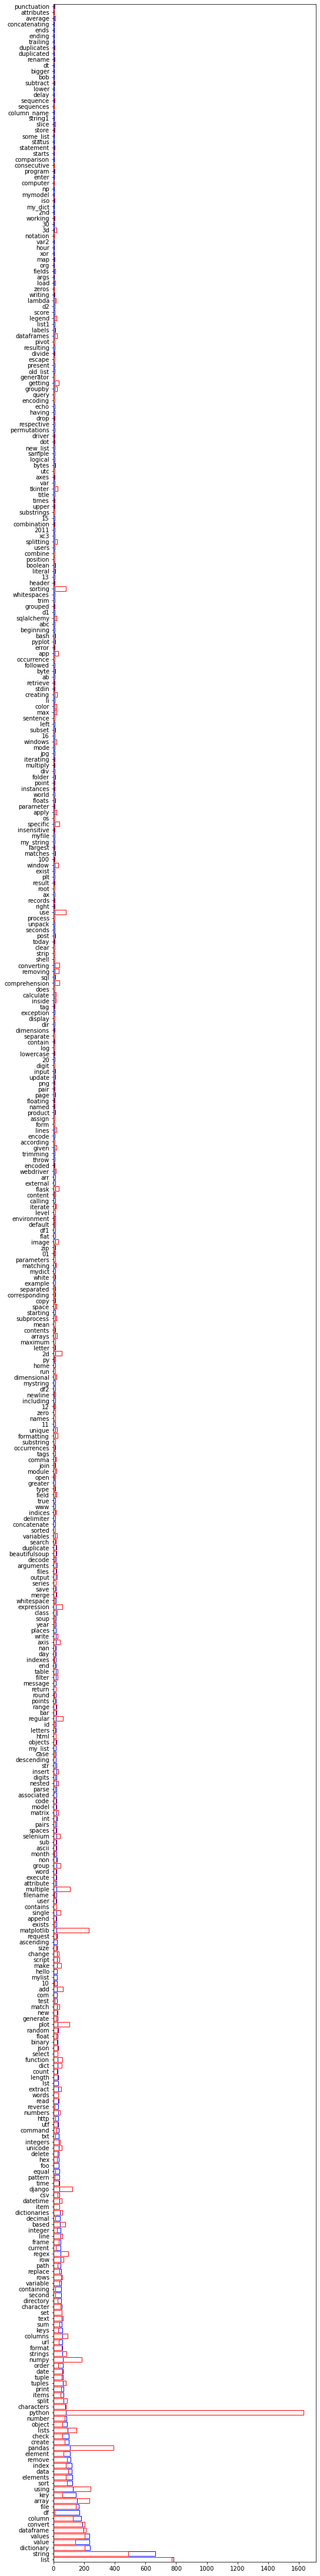

In [132]:
# Plot term frequency, mined compared with train
plt.figure(figsize=(8,80))
plt.barh(train_bag_sorted.index,train_bag_sorted["train_freq"], fill=False, edgecolor='b')
plt.barh(train_bag_sorted.index,train_bag_sorted["mined_freq"], fill=False, edgecolor='r')
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

The terms are actually quite comparable. Enough so that I'm comfortable proceeding with this for preliminary modelling.

One point in particular is worth noting. The term "python" is far more represented in the mined data. This indicates to me that the term is so frequently used that it is not actually helpful in identifying intent. This is not a surprising result since the CoNaLa competition was designed with Python code specifically being analyzed. **I'm going to drop this row** since it simply does not give valuable information seeing as the code should all be written in python anyways.

## Intent Paradigms
[[Back To TOC]](#Table-of-Contents)

We can look at the above graph to see some common themes which emerge, at least on the level of word frequency. 

- String manipulation 
- List manipulation 
- Type change
- Regular Expression
- DataFrame Manipulation
- Find object  


&&...



# Modelling and Analysis
[[Back To TOC]](#Table-of-Contents)


# Conclusion
[[Back To TOC]](#Table-of-Contents)


# References
[[Back To TOC]](#Table-of-Contents)

[1] CoNaLa: The Code/Natural Language Challenge. 2020. CoNaLa: The Code/Natural Language Challenge. [online] Available at: <https://conala-corpus.github.io/#dataset-information> [Accessed 13 November 2020].

[2] Learning to Mine Aligned Code and Natural Language Pairs from Stack Overflow. arXiv:1805.08949v1. 23 May 2018. Pengcheng Yin, Bowen Deng, Edgar Chen, Bogdan Vasilescu, Graham Neubig, Carnegie Mellon University, USA. [online]. Available at: https://arxiv.org/pdf/1805.08949.pdf